In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
from sklearn.metrics import accuracy_score

part1

In [5]:
def gini(sequence):
    
    counts = {}
    for row in sequence:
        label = row
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(sequence))
        impurity -= prob_of_lbl**2

    return impurity


def entropy(sequence):
    counts = {}
    for row in sequence:
        label = row
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    impurity = 0
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(sequence))
        impurity += - prob_of_lbl* np.log2(prob_of_lbl)
    return impurity

data = np.array([1,2,1,1,1,1,2,2,1,1,2])
print("Gini of data is ", gini(data))
print("Entropy of data is ", entropy(data))

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
print(train_df.shape)
print(val_df.shape)

train_df.head()

Gini of data is  0.4628099173553719
Entropy of data is  0.9456603046006401
(1200, 21)
(300, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1583,1,2.1,1,11,0,14,0.7,148,7,...,942,1651,1704,17,13,2,1,0,1,1
1,745,1,0.6,1,5,0,35,0.8,102,8,...,89,1538,2459,14,1,16,1,1,0,0
2,832,0,0.7,1,2,1,39,0.7,103,4,...,125,1504,1799,5,2,11,1,0,1,0
3,1175,1,1.3,0,2,0,19,0.3,164,7,...,873,1394,1944,9,4,9,1,1,0,0
4,695,0,0.5,0,18,1,12,0.6,196,2,...,1649,1829,2855,16,13,7,1,1,1,1


part2

In [6]:
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

class Question:
    '''
    store the question of each node
    '''
    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the feature value in this question.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

def class_counts(rows): 
    counts = {}
    for row in rows:
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

def partition(rows, question): # divide the dataset into two part based on the question
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    true_rows = np.array(true_rows)
    false_rows = np.array(false_rows)
    return true_rows, false_rows


def info_gain(left, right, current_uncertainty, criterion): # calculate the information gain
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * eval(criterion+"(left[:,-1])") - (1 - p) * eval(criterion+"(right[:,-1])") 

def find_best_split(rows, criterion, is_boostrap): # find the best question for the partition
    best_gain = 0 
    best_question = None 
    current_uncertainty = eval(criterion+"(rows[:,-1])")
    n_features = len(rows[0]) - 1
    if is_boostrap == 0:
        for col in range(n_features):  
            values = set([row[col] for row in rows]) 
            for val in values:
                question = Question(col, val)
                true_rows, false_rows = partition(rows, question)
                if len(true_rows) == 0 or len(false_rows) == 0:
                    continue
                gain = info_gain(true_rows, false_rows, current_uncertainty, criterion)
                if gain > best_gain:
                    best_gain, best_question = gain, question
    else:
        feature_index = random.sample(range(len(rows[0])-1), int(is_boostrap))
        #print(feature_index)
        for col in range(n_features): 
            if col in feature_index: 
                values = set([row[col] for row in rows]) 
                for val in values:
                    question = Question(col, val)
                    true_rows, false_rows = partition(rows, question)
                    if len(true_rows) == 0 or len(false_rows) == 0:
                        continue
                    gain = info_gain(true_rows, false_rows, current_uncertainty, criterion)
                    if gain >= best_gain:
                        best_gain, best_question = gain, question

    return best_gain, best_question

class Leaf: # the end of the tree
    def __init__(self, rows):
        inverse = [(value, key) for key, value in class_counts(rows).items()]
        self.predictions = max(inverse)[1]
    
class Decision_Node: # tree node
    def __init__(self,
                 question,
                 true_branch,
                 false_branch,
                 len_true_branch,
                 len_false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch
        self.len_true_branch = len_true_branch
        self.len_false_branch = len_false_branch

def classify(row, node):
    if isinstance(node, Leaf):
        return node.predictions
    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

features_counting = np.zeros(20) #part3
gini_index_adaboost = 0 #part4
class DecisionTree(): # aiming to build the decision tree
    def __init__(self, criterion='gini', max_depth=None, gini_index_adaboost=0, boostrap=False, max_features=0):
        self.criterion = criterion
        self.max_depth = max_depth
        self.gini_index_adaboost = gini_index_adaboost
        self.false_rows = []
        self.boostrap = boostrap
        self.max_features = max_features
        
 
    def build_tree(self, x_data, y_data, level): # build the decision tree
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        y_data = np.reshape(y_data, (len(y_data), 1))
        x_data = np.append(x_data, y_data, axis=1)
        data = x_data

        if self.boostrap == False:
            gain, question = find_best_split(data, self.criterion, 0)
        else:
            gain, question = find_best_split(data, self.criterion, self.max_features)
    
        if gain == 0 or level == self.max_depth:
            return Leaf(data)
        true_rows, false_rows = partition(data, question)
        self.gini_index_adaboost = info_gain(true_rows, false_rows, 1, 'gini')
        self.false_rows = false_rows
        #print(question.column, question.value, len(true_rows), len(false_rows))
        features_counting[question.column] = features_counting[question.column] + 1
        true_rows_x = true_rows[:,0:(len(true_rows[0])-1)]
        true_rows_y = true_rows[:,-1]
        false_rows_x = false_rows[:,0:(len(false_rows[0])-1)]
        false_rows_y = false_rows[:,-1]

        level = level + 1
        true_branch = self.build_tree(true_rows_x, true_rows_y, level)
        false_branch = self.build_tree(false_rows_x, false_rows_y, level)
        #self.tree = Decision_Node(question, true_branch, false_branch, len(true_rows), len(false_rows))
        return Decision_Node(question, true_branch, false_branch, len(true_rows), len(false_rows))
    
    def fit(self, x_data, y_data): 
        self.tree = self.build_tree(x_data, y_data, 0)

    def predict(self, x_test): # return the predicted y based on the decision tree
        y_pred = []
        for row in x_test:
            y_pred.append(classify(row, self.tree))
        y_pred = np.array(y_pred)
        return y_pred

clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
train_df_x = np.array(train_df.values)[:,0:(len(train_df.values[0])-1)]
train_df_y = np.array(train_df.values)[:,-1]
val_df_x = np.array(val_df.values)[:,0:(len(val_df.values[0])-1)]
val_df_y = np.array(val_df.values)[:,-1]
clf_depth3_tree = clf_depth3.fit(train_df_x, train_df_y)
y_pred = clf_depth3.predict(val_df_x)
print(accuracy_score(val_df_y, y_pred))

clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
train_df_x = np.array(train_df.values)[:,0:(len(train_df.values[0])-1)]
train_df_y = np.array(train_df.values)[:,-1]
val_df_x = np.array(val_df.values)[:,0:(len(val_df.values[0])-1)]
val_df_y = np.array(val_df.values)[:,-1]
clf_depth10_tree = clf_depth10.fit(train_df_x, train_df_y)
y_pred = clf_depth10.predict(val_df_x)
print(accuracy_score(val_df_y, y_pred))

clf_gini = DecisionTree(criterion='gini', max_depth=3)
train_df_x = np.array(train_df.values)[:,0:(len(train_df.values[0])-1)]
train_df_y = np.array(train_df.values)[:,-1]
val_df_x = np.array(val_df.values)[:,0:(len(val_df.values[0])-1)]
val_df_y = np.array(val_df.values)[:,-1]
clf_gini_tree = clf_gini.fit(train_df_x, train_df_y)
y_pred = clf_gini.predict(val_df_x)
print(accuracy_score(val_df_y, y_pred))

clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
train_df_x = np.array(train_df.values)[:,0:(len(train_df.values[0])-1)]
train_df_y = np.array(train_df.values)[:,-1]
val_df_x = np.array(val_df.values)[:,0:(len(val_df.values[0])-1)]
val_df_y = np.array(val_df.values)[:,-1]
clf_entropy_tree = clf_entropy.fit(train_df_x, train_df_y)
y_pred = clf_entropy.predict(val_df_x)
print(accuracy_score(val_df_y, y_pred))

0.92
0.93
0.92
0.9333333333333333


part3

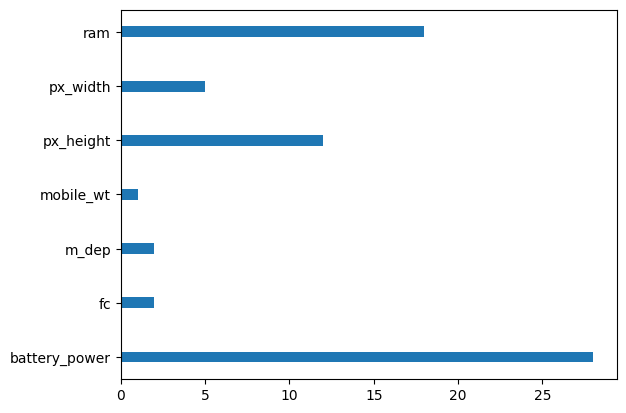

In [7]:
label = ['battery_power','blue','clock_speed','dual_sim','fc','four_g','int_memory','m_dep','mobile_wt','n_cores','pc','px_height','px_width','ram','sc_h','sc_w','talk_time','three_g','touch_screen','wifi']
new_h = []
new_label = []
new_features_counting = []
count = 1
for i in range(20):
    if features_counting[i] != 0:
        new_h.append(count)
        new_label.append(label[i])
        new_features_counting.append(features_counting[i])
        count = count + 1
new_h = np.array(new_h)
new_label = np.array(new_label)
new_features_counting = np.array(new_features_counting)
plt.barh(new_h,new_features_counting,tick_label=new_label,height=0.2)  # 改成 barh
plt.show()

part4

In [8]:
class AdaBoost:
    def __init__(self, n_estimators, max_depth=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth

    def cal_amount_of_say(self, total_error): # calculate amount_of_say
        return (1/2) * np.log((1-total_error)/total_error)

    def fit(self, x_data, y_data):
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        y_data = np.reshape(y_data, (len(y_data), 1))
        x_data = np.append(x_data, y_data, axis=1)
        #y_data = np.reshape(y_data, len(y_data))
        data = x_data

        n_column = len(data[0])
        n_row = len(data)

        self.clfs = []
        self.amount_of_say = []

        w = np.full(n_row, (1 / n_row))
        update_data = data

        for j in range(self.n_estimators):
            amount_of_say = 0

            clf = DecisionTree(criterion='gini', max_depth=self.max_depth)
            clf.fit(update_data[:,0:(len(update_data[0])-1)], update_data[:,-1])
            clf_tree = clf.tree
            total_error = 0
            for i in range(len(data)):
                if classify(data[i],clf_tree) != data[i][-1]:
                    total_error = total_error + w[i]
            
            amount_of_say = self.cal_amount_of_say(total_error)
            self.amount_of_say.append(amount_of_say)
            self.clfs.append(clf_tree)

            for i in range(n_row):
                if classify(data[i],clf_tree) == data[i][-1]:
                    w[i] = w[i] * np.exp(-amount_of_say)
                else:
                    w[i] = w[i] * np.exp(amount_of_say)
            w = np.array(w)
            w = w / w.sum(axis=0,keepdims=1)
            new_data = np.empty(shape=(n_row,n_column))
            new_data.fill(0)
            index = []
            for i in range(n_row):
                index.append(i)
            w = w.tolist()
            index = np.random.choice(data.shape[0], data.shape[0], replace=True, p=w)
            index = index.tolist()
            update_data = np.empty(shape=(data.shape[0],data.shape[1]))
            update_data.fill(0)
            for i in range(data.shape[0]):
                update_data[i] = data[index[i]]

    def predict(self, x_test):
        answer = []
        for i in range(len(x_test)):
            amount_of_say_0 = 0
            amount_of_say_1 = 0
            j = 0
            for clf in self.clfs:
                category = classify(x_test[i],clf)
                if category == 0:
                    amount_of_say_0 += self.amount_of_say[j]
                else:
                    amount_of_say_1 += self.amount_of_say[j]
                j = j + 1
            if amount_of_say_0 > amount_of_say_1:
                answer.append(0)
            else:
                answer.append(1)
        return answer


clf_estimate10 = AdaBoost(10)
train_df_x = np.array(train_df.values)[:,0:(len(train_df.values[0])-1)]
train_df_y = np.array(train_df.values)[:,-1]
val_df_x = np.array(val_df.values)[:,0:(len(val_df.values[0])-1)]
val_df_y = np.array(val_df.values)[:,-1]
clf_estimate10_tree = clf_estimate10.fit(train_df_x, train_df_y)
y_pred = clf_estimate10.predict(val_df_x)
print(accuracy_score(val_df_y, y_pred))

clf_estimate100 = AdaBoost(100)
train_df_x = np.array(train_df.values)[:,0:(len(train_df.values[0])-1)]
train_df_y = np.array(train_df.values)[:,-1]
val_df_x = np.array(val_df.values)[:,0:(len(val_df.values[0])-1)]
val_df_y = np.array(val_df.values)[:,-1]
clf_estimate100_tree = clf_estimate100.fit(train_df_x, train_df_y)
y_pred = clf_estimate100.predict(val_df_x)
print(accuracy_score(val_df_y, y_pred))

0.9266666666666666
0.9733333333333334


part5

In [10]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth

    def fit(self, x_data, y_data):
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        y_data = np.reshape(y_data, (len(y_data), 1))
        x_data = np.append(x_data, y_data, axis=1)
        #y_data = np.reshape(y_data, len(y_data))
        data = x_data
        self.clfs = []
        
        for i in range(self.n_estimators):
            #print(i)
            data_random = []
            for j in range(len(data)):
                index = random.randint(0, len(data)-1)
                data_random = np.array(data_random)
                data_random = np.append(data_random, data[index])
            data_random = np.reshape(data_random, (len(data),len(data[0])))

            clf = DecisionTree(criterion='gini', max_depth=None, boostrap=True, max_features=self.max_features)
            clf.fit(data_random[:,0:(len(data_random[0])-1)], data_random[:,-1])
            clf_tree = clf.tree
            self.clfs.append(clf_tree)
            

    def predict(self, x_test):
        answer = []
        for i in range(len(x_test)):
            class_0 = 0
            class_1 = 0
            for clf in self.clfs:
                #print(data[i])
                category = classify(x_test[i],clf)
                if category == 0:
                    class_0 += 1
                else:
                    class_1 += 1
            if class_0 < class_1:
                answer.append(1)
            else:
                answer.append(0)
        return answer

train_df_x = np.array(train_df.values)[:,0:(len(train_df.values[0])-1)]
train_df_y = np.array(train_df.values)[:,-1]
val_df_x = np.array(val_df.values)[:,0:(len(val_df.values[0])-1)]
val_df_y = np.array(val_df.values)[:,-1]


clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(len(train_df_x[0])))
clf_10tree_tree = clf_10tree.fit(train_df_x, train_df_y)
y_pred = clf_10tree.predict(val_df_x)
print(accuracy_score(val_df_y, y_pred))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(len(train_df_x[0])))
clf_100tree_tree = clf_100tree.fit(train_df_x, train_df_y)
y_pred = clf_100tree.predict(val_df_x)
print(accuracy_score(val_df_y, y_pred))
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(len(train_df_x[0])))
clf_random_features_tree = clf_random_features.fit(train_df_x, train_df_y)
y_pred = clf_random_features.predict(val_df_x)
print(accuracy_score(val_df_y, y_pred))
clf_all_features = RandomForest(n_estimators=10, max_features=len(train_df_x[0]))
clf_all_features_tree = clf_all_features.fit(train_df_x, train_df_y)
y_pred = clf_all_features.predict(val_df_x)
print(accuracy_score(val_df_y, y_pred))

0.92
0.9466666666666667
0.9366666666666666
0.9566666666666667


part6

In [12]:

def train_your_model(data):
    
    model = AdaBoost(150, 3)
    #print("haha")
    train_df_x = np.array(data)[:,0:(len(data[0])-1)]
    train_df_y = np.array(data)[:,-1]
    #print("haha")
    model.fit(train_df_x, train_df_y)
    return model
# train_df_x = np.array(train_df.values)[:,0:(len(train_df.values[0])-1)]
# train_df_y = np.array(train_df.values)[:,-1]
my_model = train_your_model(train_df.values)
# y_pred = my_model.predict(val_df_x)
# val_df_x = np.array(val_df.values)[:,0:(len(val_df.values[0])-1)]
# val_df_y = np.array(val_df.values)[:,-1]
# print(accuracy_score(val_df_y, y_pred))

'''
    Some Code to train your "my_model"
'''

x_test = pd.read_csv('x_test.csv')
y_pred = my_model.predict(x_test.values)


with open('model.pickle', 'wb') as pkl_file:
    pickle.dump(my_model, pkl_file, protocol=pickle.HIGHEST_PROTOCOL)

np.save("y_pred.npy", y_pred)

checker

In [ ]:
# y_test = pd.read_csv('y_test.csv')['price_range'].values
# print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )


score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")




*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
